<a href="https://colab.research.google.com/github/otavioml/Chess-Data-Analysis/blob/main/Chess_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de partidas de xadrez do Lichess



##Imports e leitura da base de dados

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as ss

In [92]:
plt.rcParams['figure.figsize']  = (16, 14)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [93]:
df = pd.read_csv('https://raw.githubusercontent.com/otavioml/Chess-Data-Analysis/main/Chess10k.csv')

## Limpeza dos dados e adição de novas colunas

In [94]:
#Limpeza dos dados
#Padronização do tipo da coluna Numer_of_Moves
df['Number_of_Moves'] =  pd.to_numeric(df['Number_of_Moves'], errors='coerce')

#Remoção das partidas com menos de 3 movimentos que foram abandonadas ou terminadas por tempo
condition = (df['Number_of_Moves'] >= 3) | (df['Termination'] == 'Normal')
df = df.loc[condition]

#limpeza das linhas nulas
df = df.dropna()

In [95]:
#Adição das colunas média e razão
#RatioElo = Maior elo da partida dividido pelo menor elo da partida, quanto mais próximo de 1 mais igual foi a disputa
df['RatioElo'] = df.apply(lambda x: x['BlackElo']/x['WhiteElo'] if x['BlackElo']>x['WhiteElo'] else x['WhiteElo']/x['BlackElo'], axis = 1)
df['MatchElo'] = (df['BlackElo']+df['WhiteElo'])/2

#Colunas de interesse
df = df[['WhiteElo','BlackElo','RatioElo','MatchElo','Winner','InitialTime','Increment','TimeControl','Opening','ECO','Number_of_Moves','Site']]
df.shape

(9968, 12)

##Dataframe Final e dados sobre as colunas

In [96]:
df.head()

,WhiteElo,BlackElo,RatioElo,MatchElo,Winner,InitialTime,Increment,TimeControl,Opening,ECO,Number_of_Moves,Site
0,1639,1403,1.168211,1521.0,White,600,8,Rapid,French Defense: Normal Variation,C00,13,https://lichess.org/j1dkb5dw
1,1654,1919,1.160218,1786.5,White,480,2,Rapid,"Queen's Pawn Game: Colle System, Anti-Colle",D04,18,https://lichess.org/a9tcp02g
2,1643,1747,1.063299,1695.0,White,420,17,Rapid,Four Knights Game: Italian Variation,C50,11,https://lichess.org/szom2tog
3,1824,1973,1.081689,1898.5,Black,60,1,Bullet,Caro-Kann Defense: Goldman Variation,B12,47,https://lichess.org/rklpc7mk
4,1765,1815,1.028329,1790.0,Black,60,1,Bullet,French Defense: La Bourdonnais Variation,C00,23,https://lichess.org/1xb3os63


In [97]:
#Short description of the dataframe
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,WhiteElo,BlackElo,RatioElo,MatchElo,InitialTime,Increment,Number_of_Moves
count,9968.00,9968.00,9968.00,9968.00,9968.00,9968.00,9968.00
mean,1606.68,1597.64,1.11,1602.16,313.34,2.96,32.95
std,200.46,207.63,0.11,175.65,304.64,4.89,16.55
min,891.00,856.00,1.00,989.50,0.00,0.00,1.00
25%,1479.00,1461.00,1.04,1481.50,120.00,0.00,22.00
50%,1604.00,1582.00,1.08,1589.00,300.00,1.00,31.00
75%,1733.00,1735.00,1.15,1724.00,420.00,5.00,42.00
max,2363.00,2240.00,2.05,2155.00,1800.00,30.00,122.00


##Primeiras Visualizações

In [98]:
#df.hist(bins=20, column=['WhiteElo', 'BlackElo', 'RatioElo', 'MatchElo', 'Number_of_Moves'],edgecolor='black',)
titles = ('MatchElo', 'Number_of_Moves')
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles= titles
)

fig.add_trace(
    go.Histogram(x=df['MatchElo'], nbinsx=50),
    row = 1, col = 1
)
fig.update_xaxes(title_text='Rank Médio da Partida', row=1, col=1)

fig.add_trace(
    go.Histogram(x=df['Number_of_Moves'],nbinsx=50),
    row = 1, col = 2
)
fig.update_xaxes(title_text='Número de Movimentos da Partida', row=1, col=2)

fig.update_layout(showlegend=False,
                  height=400, width=900,
                  title_text='Visão Geral (Histogramas)')

In [99]:
titles = ('RatioElo', 'InitialTime')
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles= titles
)
fig.add_trace(
    go.Box(y=df['RatioElo'], boxpoints=False),
    row = 1, col = 1
)
fig.update_yaxes(title_text='Elo', row=1, col=1)

fig.add_trace(
    go.Box(y=df['InitialTime'], boxpoints=False),
    row = 1, col = 2
)
fig.update_yaxes(title_text='Tempo(s)', row=1, col=2)

fig.update_layout(showlegend=False,
                  height=450, width=900,
                  title_text='Visão Geral (Boxplots)')


##Análises Iniciais


In [100]:
df_winner = df[df['Winner'] != 'Draw'].groupby('Winner').count()['ECO'] #Número de vitórias de cada cor
fig = px.bar(df_winner, x=df_winner.index, y='ECO')
fig.update_layout(height=450, width=500, title_text='Vitórias por cor')
fig.update_yaxes(title_text='Vitórias')
fig.update_xaxes(title_text='Cor')
fig.show()

Utilizando a média do número de movimentos como dado amostral, podemos provar que o mesmo dado amostral tende a igualar com o dado real a medida que o tamanho da amostra aumente.

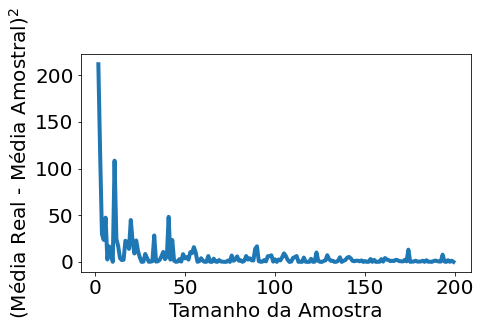

In [101]:


real_mean = df['Number_of_Moves'].mean()

sizes = np.arange(2, 200)
diff = []
for size in sizes:
  df_sample = df.sample(size, replace=True)
  diff.append((real_mean - df_sample['Number_of_Moves'].mean()) ** 2)

plt.figure(figsize=(7,4))
plt.plot(sizes, diff)
plt.ylabel('(Média Real - Média Amostral)$^2$')
plt.xlabel('Tamanho da Amostra')
plt.show()

#Como mostrado no gráfico abaixo, temos garantia que 100000 dados representa 
#a população com assiduidade, resultando em um erro muito próximo ou se não
#igual a 0

Como mostrado no gráfico acima, temos garantia que 100000 dados representa a população com assiduidade, resultando em um erro muito próximo ou se não igual a 0.

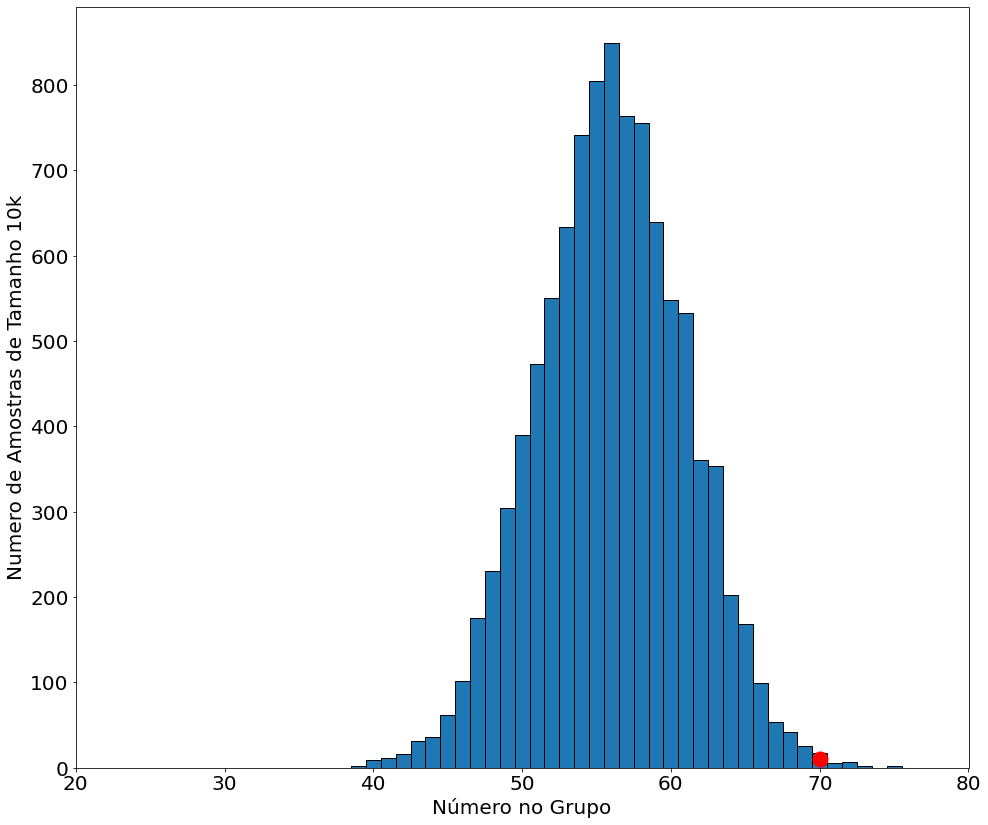

In [102]:
def sample_proportion(pop_size, proportion, n=10000):
  group = pop_size * proportion
  results = np.zeros(n)
  for i in range(n):
    sample = np.random.randint(0, pop_size, 100)
    results[i] = np.sum(sample < group)

  return results

proportions = sample_proportion(pop_size=100000, proportion=0.56)
bins = np.linspace(1, 100, 100) + 0.5
plt.hist(proportions, bins=bins, edgecolor='k')
plt.xlim(20, 80)
plt.ylabel('Numero de Amostras de Tamanho 10k')
plt.xlabel('Número no Grupo')
plt.plot([70], [10], 'ro', ms=15)
plt.show()

In [103]:
np.percentile(proportions, 95)

64.0

Com 5% de chances podemos ter 64% de vitória das brancas. 70% de vitórias das brancas já é um resultado bem raro baseado na distribuição anterior.

In [104]:
"""A função lista em um dataframe, as 10 aberturas mais utilizadas
e a porcentagem de vitórias de cada cor com ela
data = dataframe analisado
n = número mínimo de partidas jogadas com cada abertura
all_lines = True retorna o dataframe completo, False retorna apnas as 10 aberturas mais usadas
reset_index = True reconstrói o index do dataframe 

retorno = 10 aberturas mais usadas """

aberturas = list(df['Opening'].unique())

def top10_openings(data, n=100, all_lines=False, reset_index=False, orderby = 'Games'):
  linhas = list()
  for abertura in aberturas:
    df_ab = data[data['Opening'] == abertura][['Opening', 'Winner']]
    ww = (df_ab[df_ab['Winner'] == 'White']['Winner'].count())
    bw = (df_ab[df_ab['Winner'] == 'Black']['Winner'].count())
    total = bw + ww
    linhas.append([abertura, total, ww, bw])
  df_aberturas = pd.DataFrame(data=linhas, columns=['Opening','Total','WhiteWins','BlackWins'])
  df_aberturas = df_aberturas[df_aberturas['Total']>n]
  df_aberturas['WhiteWins_percent'] = ((df_aberturas['WhiteWins']/(df_aberturas['WhiteWins']+df_aberturas['BlackWins']))*100).round(2)
  df_aberturas['BlackWins_percent'] = 100 - df_aberturas['WhiteWins_percent']

  if orderby == 'Games':
    df_aberturas = df_aberturas.sort_values(by=['Total'], ascending=False)
  else:
      df_aberturas = df_aberturas.sort_values(by=[orderby+'Wins_percent'], ascending=False)

  if reset_index:
    df_aberturas.reset_index(inplace=True)

  if all_lines:
    return df_aberturas
  return df_aberturas[:10]

In [105]:
top_black_opening = top10_openings(df, orderby='Black')
top_white_opening = top10_openings(df, orderby='White')
top_opening = top10_openings(df,reset_index=True)

In [106]:
top_black_opening

,Opening,Total,WhiteWins,BlackWins,WhiteWins_percent,BlackWins_percent
91,Sicilian Defense: Bowdler Attack,147,45,102,30.61,69.39
191,King's Pawn Game: Wayward Queen Attack,114,47,67,41.23,58.77
32,Van't Kruijs Opening,370,161,209,43.51,56.49
148,Queen's Pawn Game,130,61,69,46.92,53.08
245,Hungarian Opening,101,48,53,47.52,52.48
30,Sicilian Defense,123,60,63,48.78,51.22
35,Caro-Kann Defense,115,57,58,49.57,50.43
64,French Defense: Knight Variation,145,79,66,54.48,45.52
10,Modern Defense,184,101,83,54.89,45.11
5,Owen Defense,166,93,73,56.02,43.98


In [107]:
top_white_opening

,Opening,Total,WhiteWins,BlackWins,WhiteWins_percent,BlackWins_percent
53,Philidor Defense #3,135,93,42,68.89,31.11
255,Queen's Pawn Game: Chigorin Variation,141,96,45,68.09,31.91
17,Scandinavian Defense: Mieses-Kotroc Variation,210,135,75,64.29,35.71
92,Queen's Pawn Game #2,101,64,37,63.37,36.63
23,Horwitz Defense,146,91,55,62.33,37.67
31,Scandinavian Defense,153,90,63,58.82,41.18
5,Owen Defense,166,93,73,56.02,43.98
10,Modern Defense,184,101,83,54.89,45.11
64,French Defense: Knight Variation,145,79,66,54.48,45.52
35,Caro-Kann Defense,115,57,58,49.57,50.43


In [108]:
top_opening

,index,Opening,Total,WhiteWins,BlackWins,WhiteWins_percent,BlackWins_percent
0,32,Van't Kruijs Opening,370,161,209,43.51,56.49
1,17,Scandinavian Defense: Mieses-Kotroc Variation,210,135,75,64.29,35.71
2,10,Modern Defense,184,101,83,54.89,45.11
3,5,Owen Defense,166,93,73,56.02,43.98
4,31,Scandinavian Defense,153,90,63,58.82,41.18
5,91,Sicilian Defense: Bowdler Attack,147,45,102,30.61,69.39
6,23,Horwitz Defense,146,91,55,62.33,37.67
7,64,French Defense: Knight Variation,145,79,66,54.48,45.52
8,255,Queen's Pawn Game: Chigorin Variation,141,96,45,68.09,31.91
9,53,Philidor Defense #3,135,93,42,68.89,31.11


In [109]:
aberturas_analise = pd.concat([top_opening[:3],(top_white_opening[:3]),(top_black_opening[:3])])
aberturas_analise = aberturas_analise.drop('index',axis=1).drop_duplicates().reset_index(drop=True)
aberturas_analise

,Opening,Total,WhiteWins,BlackWins,WhiteWins_percent,BlackWins_percent
0,Van't Kruijs Opening,370,161,209,43.51,56.49
1,Scandinavian Defense: Mieses-Kotroc Variation,210,135,75,64.29,35.71
2,Modern Defense,184,101,83,54.89,45.11
3,Philidor Defense #3,135,93,42,68.89,31.11
4,Queen's Pawn Game: Chigorin Variation,141,96,45,68.09,31.91
5,Sicilian Defense: Bowdler Attack,147,45,102,30.61,69.39
6,King's Pawn Game: Wayward Queen Attack,114,47,67,41.23,58.77


Hipótese núla: A abertura não influencia a média de vitórias observadas

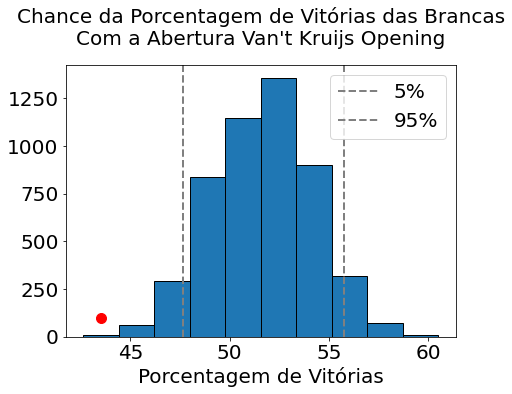

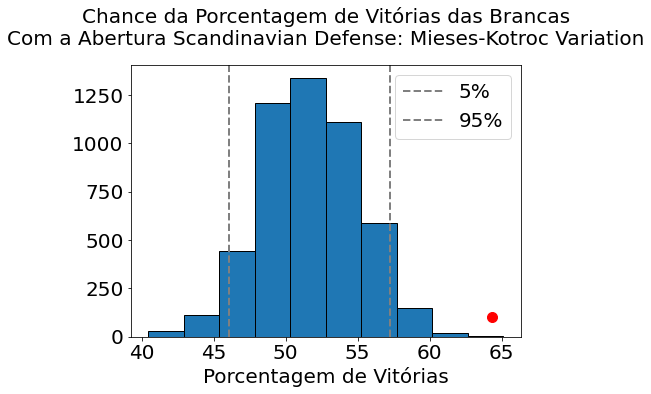

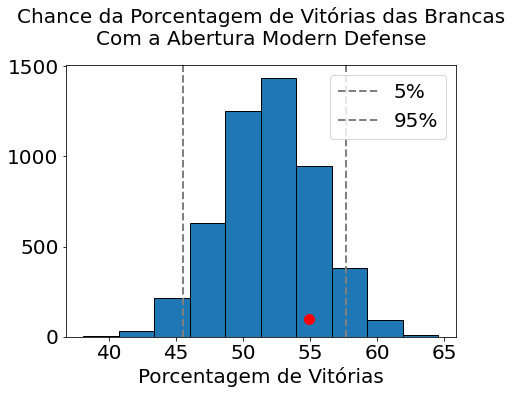

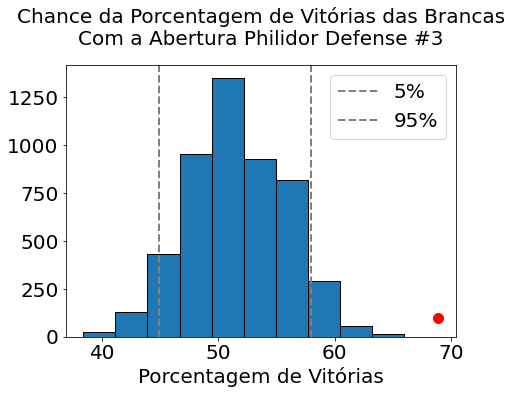

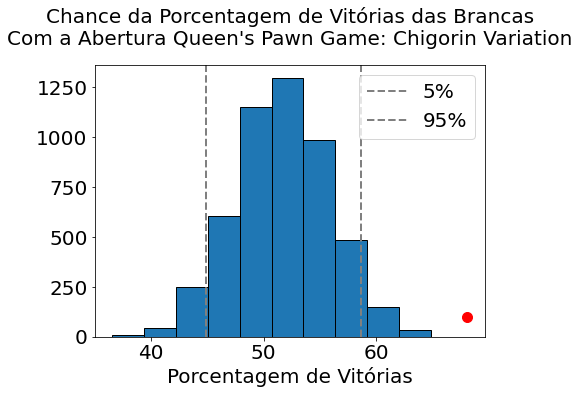

In [110]:
"""Plota um histograma dos valores aleatórios e seu intervalo de confiança
Plota um ponto representando a estatística de teste

parametros:
values = int[]: lista com os valores do teste de permutação
test = float: estatística de teste observada no conjunto de dados original
open = str: abertura analisada
wins: "White" ou "Black": Referente à qual cor estamos analizando"""

def icplot(values, test, open, wins):
  plt.figure(figsize=(7,5))
  wins = 'Brancas' if wins == 'White' else 'Pretas'
  plt.hist(values, edgecolor='k')
  plt.title(f'Chance da Porcentagem de Vitórias das {wins}\nCom a Abertura {open}', pad=20)
  plt.xlabel('Porcentagem de Vitórias')
  plt.plot([test], [100], 'ro', ms=10)
  LI = np.percentile(values, 5)
  LS = np.percentile(values,95)
  plt.axvline(x=LI, color = 'gray', linestyle='dashed', linewidth = 2, label='5%')
  plt.axvline(x=LS, color = 'gray', linestyle='dashed', linewidth = 2, label='95%')
  plt.legend()
  plt.show()


def build_filtro(openings):
  category = list(np.zeros(len(df)))
  for i, open in enumerate(openings):
    aux = (1*(df['Opening'] == open)).replace(1,i+1)
    category += aux
  return list(category)

def ic_openings(df_openings, n_op=5, wins='White'):
  openings = df_openings[:n_op]['Opening']
  observado = df_openings[:n_op][f'{wins}Wins_percent']
  df_copy = df.copy()
  filtro = build_filtro(openings)
  n = 5000
  result = np.zeros((n_op,n))
  
  for i in range(n):
    np.random.seed(i)
    np.random.shuffle(filtro)
    df_copy['Filtro'] = filtro
    for j in range(1,n_op+1):
      random_open = df_copy[df_copy['Filtro']==j]
      m0 = (random_open['Winner']==wins).sum()
      result[j-1,i] = (m0*100)/len(random_open)
  
  for i in range(n_op):
    icplot(result[i],observado[i],openings[i],wins)

ic_openings(aberturas_analise)

##Funções para Regressão

In [111]:
def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0]
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

In [112]:
 def plotGrafico(ax, dataframe, coluna1, coluna2):
  
  x = dataframe[coluna1]
  y = dataframe[coluna2]

  alpha, beta = least_squares_fit(x, y)
  y_model = beta * x + alpha
  ax.plot(x, y_model, color='magenta')
  ax.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
  ax.set(xlabel=coluna1, ylabel=coluna2)

In [113]:
def reg_by_elo (tipoPartida, sample=1000):

  temp = df.where(df['TimeControl'] == tipoPartida ).dropna()#.sample(sample)
  eloMean = temp['RatioElo'].mean()
  temp = temp[temp['RatioElo'] < eloMean]


  x = temp['Number_of_Moves']
  y = temp['MatchElo']
  print(x.corr(y, method= 'pearson'))

  alpha, beta = least_squares_fit(x, y)
  y_model = beta * x + alpha
  plt.figure(figsize=(7,4))
  plt.plot(x, y_model, color='magenta')
  plt.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
  plt.xlabel('Número de Movimentos')
  plt.ylabel('MatchElo')
  plt.title('Elo Mais Equilibrada')
  plt.show()

  temp = df.where(df['TimeControl'] == 'Bullet').dropna()#.sample(sample)
  eloMean = temp['RatioElo'].mean()
  temp = temp[temp['RatioElo'] > eloMean]


  x = temp['Number_of_Moves']
  y = temp['MatchElo']
  print(x.corr(y, method= 'pearson'))


  alpha, beta = least_squares_fit(x, y)
  y_model = beta * x + alpha
  plt.figure(figsize=(7,4))
  plt.plot(x, y_model, color='magenta')
  plt.scatter(x, y, alpha=0.8, edgecolors='k', s=40)
  plt.ylabel('MatchElo ')
  plt.xlabel('Número de Movimentos')
  plt.title('Elo Menos Equilibrado')
  plt.show()

In [114]:
def reglin (tipoPartida, variavel, sample = 10000, escala = False,):

  temp = df.where(df['TimeControl'] == tipoPartida ).dropna()#.sample(sample)


  p25 = np.quantile(temp['MatchElo'], .25)
  p50 = np.quantile(temp['MatchElo'], .5)
  p75 = np.quantile(temp['MatchElo'], .75)

  q1 = temp[temp['MatchElo'] < p25]
  q2 = temp[(temp['MatchElo'] > p25) & (temp['MatchElo'] < p50)]
  q3 = temp[(temp['MatchElo'] > p50) & (temp['MatchElo'] < p75)]
  q4 = temp[temp['MatchElo'] > p75]

  x_min = temp[variavel].min()
  x_max = temp[variavel].max()
    
    

  fig, axes = plt.subplots(nrows=2, ncols=2)
  fig.suptitle("correlação entre entre numero de movimentos e " + variavel + " em partidas " + tipoPartida )
  axes[0,0].set_title("Primeiro Quartil")
  axes[0,0].set_ylim(0.0,100.0)
  plotGrafico(axes[0,0], q1, variavel, 'Number_of_Moves')
  axes[0,1].set_title("Segundo Quartil")
  axes[0,1].set_ylim(0.0,100.0)
  plotGrafico(axes[0,1], q2, variavel, 'Number_of_Moves')
  axes[1,0].set_title("Terceiro Quartil")
  axes[1,0].set_ylim(0.0,100.0)
  plotGrafico(axes[1,0], q3, variavel, 'Number_of_Moves')
  axes[1,1].set_title("Quarto Quartil")
  axes[1,1].set_ylim(0.0,100.0)
  plotGrafico(axes[1,1], q4, variavel, 'Number_of_Moves')

##Análise dos Tipos de Partida

Nesta seção análises são feitas usando o atributo TipoPartida como filtro, em que relacionamos a quantidade do Número de Movimentos em ralação ao MatchElo e RatioElo.

MatchElo: Média entre o ranking dos dois jogadores da partida. 

RatioElo: Razão entre maior e menor elo. 



###Tipo de Partida : Bullet - partidas de duração de até 1 minuto



Observa-se no gráfico abaixo que as partidas em que o Elo é menos equilibrado possui um correlação relativamente maior com os números de movimento, embora em ambos os casos a correlação seja baixa.

In [115]:
reg_by_elo('Bullet', escala = True)

TypeError: ignored

Considerando as partidas mais equilibradas, ou seja, com um RatioElo menor, o Coeficiente de Pearson (0.26 aproximadamente) é menor do que nas partidas menos equilibradas. Logo, quando os pares de elos possuem um nível de experiência mais parecido, o número de movimentos diminui. Embora para ambos os casos a correlação seja baixa. 


In [ ]:
reglin('Bullet', "MatchElo",escala = True)

Conforme os plots, no primeiro quartil, em que o elo é mais fraco (1200 a 1500) é perceptível a influência no número de movimentos, assim como quando o elo é forte (1800 a 2100). Já nos elos intermediários, segundo e terceiro quartis, há uma distribuição mais homogênea e a correlação não é tão notável. 

In [ ]:
reglin('Bullet', 'RatioElo', escala = True)


Nos plots acima 

### Tipo de Partida: Blitz - partidas com duração de até 3 minutos

In [ ]:
reg_by_elo('Blitz')

In [ ]:
reglin('Blitz', "MatchElo",escala = True)

In [ ]:

reglin('Blitz','RatioElo',escala = True)

### Tipo de Partida: Rapid - partidas com duração de até 10 minutos

In [ ]:
reg_by_elo('Rapid')

In [ ]:
reglin('Rapid', "MatchElo",escala = True)

In [ ]:
reglin('Rapid','RatioElo',escala = True)

###Aplicação da Regressão Múltipla

In [ ]:
# Faz uma regressão linear com base nos valores de X e Y
def regressaoLinear(X, Y, returnAll = False, returnY_hat=False, returnBeta = False):
    
    # popula a matriz X com uma coluna de 1's
    b0_ones = np.ones((X.shape[0],1))
    try:
        X_mat = np.append(b0_ones, X, axis=1)
    except:
        X_mat = np.array([np.ones(len(X)), X]).T
    
    #calcula vetor de betas a partir do metodo dos mínimos quadrados
    beta = np.linalg.lstsq(X_mat, Y, rcond=-1)[0]
    
    #retorna de acortdo com as especificações
    if returnBeta:
        return beta
    if returnY_hat:
        y_hat = X_mat @ beta
        return y_hat
   
    if returnAll:
        y_hat =  X_mat @ beta
        return X_mat, beta, y_hat
    return  X_mat, beta

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [ ]:
def avaliarClassificador(y_hat, y ): 

    # Métricas
    precision, recall, Fscore, Suport = precision_recall_fscore_support(y_hat, y, average=None, pos_label=1)
    
    accuracy = accuracy_score(y_hat, y)
    print("Acurácia: %.2f" % (accuracy))
    print("Suporte: positivo - %d, negativo - %d" % (Suport[1], Suport[0]))
    print('PPV (precision) | Sensibilidade(Recall) |  Especificidade   | F1')
    print("%.2f            |          %.2f         |        %.2f       | %.2f" %(precision[1], recall[1], recall[0], Fscore[1]))
    
    return 

def erro(X, y, theta):
    return y - X@theta

def multiple_r_squared(X, y, theta):
    sse = sum(erro(X, y, theta)**2)
    sst = sum((y - np.mean(y))**2)
    return 1.0 - sse / sst

In [ ]:
def plotarRegressao(X,Y, idx=None, titulo = None, comparacao=False, save=False, beta=None, plotar = True):
    
    

    # Caso o beta seja fornecido o Y_hat é calculado a partir dele, caso não seja uma regresasão será chamada
    try:
        X_mat = regressaoLinear(X,Y)[0]
        Y_hat = X_mat @ beta 
    except:
        Y_hat = regressaoLinear(X,Y, returnY_hat=True)

    print((Y_hat.shape), Y.shape)    
    # caso o objetivo seja apenas ves o Y_hat da plotagem retorna T_hat
    if not plotar:
            return Y_hat
      

    # Coloca Título na figura
    if titulo:
        plt.suptitle(titulo)

    # Caso deseje comparar com o gráficos co X de base plota a regressão e a matriz X
    if comparacao:
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.set_title('Y')
        linha1 = ax1.plot(Y, label='valor real')
        linha2 = ax1.plot(Y.index, Y_hat, label='previsão')
        ax2.set_title('X')
        ax2.plot(X)
        plt.show()
        
    # Plota apenas a regressão e o valor real
    else:
        plt.plot(Y, label='valor real')
        plt.plot(Y_hat, label='previsão')
        plt.legend()
        plt.show()
        
        
    # Salva a imagem com o nome do titulo ou com nome padrão
    if save:
        if titulo:
            plt.savefig(imageFolder + titulo + '.png')
        else:
            plt.savefig(imageFolder +  'Regressao.png')
     
    # Retorna os valores plotados
    return Y_hat


In [ ]:
def ordered_test_split(X, y, test_size=0.33, seed=7):
  np.random.seed(seed)
  trainidx = np.arange(len(y))
  testidx = np.random.choice(trainidx, int(len(trainidx)*test_size))
  testidx.sort()
  deletemask = np.where(trainidx == testidx)
  trainidx = np.delete(trainidx, deletemask)
  trainidx.shape, testidx.shape, len(trainidx), len(testidx), len(y)
  return X[trainidx,:], X[testidx,:], y[trainidx], y[testidx]

In [ ]:
def plotarDispersao(y, y_hat):
  plt.scatter(y, y_hat, alpha=0.8, edgecolors='k', s=40)
  plt.xlabel('Número de Movimentos')
  plt.ylabel('Previsão para o Numero de Movimentos')
  plt.show()

In [ ]:
atributos = ['RatioElo', 'MatchElo', 'InitialTime', 'Increment']
target = 'Number_of_Moves'
def avaliar_regressao(df, atributos, target=target, sample=100):
  
  df_copy = df.copy().sort_values(by=target)

  X = df_copy[atributos].values
  y = df_copy[target].values

  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7) 
  X_train, X_test, y_train, y_test = ordered_test_split(X, y)
  
  treino_X, theta, treino_Y = regressaoLinear(X_train, y_train, returnAll = True)
  teste_X, theta2, treino_Y = regressaoLinear(X_test, y_test, returnAll = True)

  print("R2 em treino sem regularizacao = ", multiple_r_squared(treino_X, y_train, theta))
  print("R2 em teste sem regularizacao = ", multiple_r_squared(teste_X, y_test, theta))


  y_hat = plotarRegressao(teste_X, y_test, beta=theta)
  plotarDispersao(y_test, y_hat)
  return

In [ ]:
atributos = ['RatioElo', 'MatchElo', 'InitialTime', 'Increment']
target = 'Number_of_Moves'

avaliar_regressao(df, atributos)

In [ ]:
atributos = ['RatioElo', 'MatchElo']
target = 'Number_of_Moves'

avaliar_regressao(df, atributos)